In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

from methods.utils import dynamic
from methods import mmca, mcmc
from methods.utils import update_social_attention, dynamic, calculate_susceptibility

from methods.mmca_threshold import MMCA_threshold

from parameters import Initial_data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda
Using device: cuda


In [2]:
# 导入默认参数
file_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'parameters/inital_data_1.pkl')
with open(file_path, 'rb') as f:
    init_data = pickle.load(f)

epi_paras = torch.tensor(init_data['epi_paras'], dtype=torch.float32).to(device)
soc_paras = torch.tensor(init_data['soc_paras'], dtype=torch.float32).to(device)
I_rows, I_cols = init_data['I_matrix'].nonzero()
I_edge_index = torch.tensor(np.array([I_rows, I_cols]), dtype=torch.long).to(device)
P_matrix = init_data['P_matrix']

In [ ]:
para_len = 50
node_num =  epi_paras.shape[0]
soc_paras_gl_kgh_mmca = soc_paras.unsqueeze(0).repeat(para_len, 1)
epi_paras_gl_kgh_mmca = epi_paras.unsqueeze(0).repeat(para_len, 1, 1)

#  替换掉自己的参数
gl_values = torch.linspace(0, 0.5, 50).to(device)
kgh_values = torch.linspace(0, 1, para_len).to(device)
# soc_paras_gl_kgh_mmca[...,2] = gl_values

soc_paras_gl_kgh_mmca[...,6] = kgh_values 

mmca_threshold = MMCA_threshold()
gl_kgh_threshold = torch.zeros(gl_values.shape[0],kgh_values.shape[0])

init_pA =  torch.rand(para_len, node_num).to(device)
max_iter = 1000
tol = 1e-16
process = 0
for i in range(gl_values.shape[0]):
    soc_paras_gl_kgh_mmca[...,2] = gl_values[i]
    p_A = mmca_threshold.iteration(max_iter, tol, init_pA, epi_paras_gl_kgh_mmca, soc_paras_gl_kgh_mmca,\
                                    I_edge_index)
    # p_A = mmca_threshold.mean_pA(epi_paras_gl_kgh_mmca, soc_paras_gl_kgh_mmca, I_edge_index)
    beta_mu_3 = mmca_threshold.degree_MCMC_threshold(p_A, epi_paras_gl_kgh_mmca, soc_paras_gl_kgh_mmca, P_matrix)
    gl_kgh_threshold[i,:] = beta_mu_3
    process += 1
    print(f'已经完成第 {process} 个数据！')

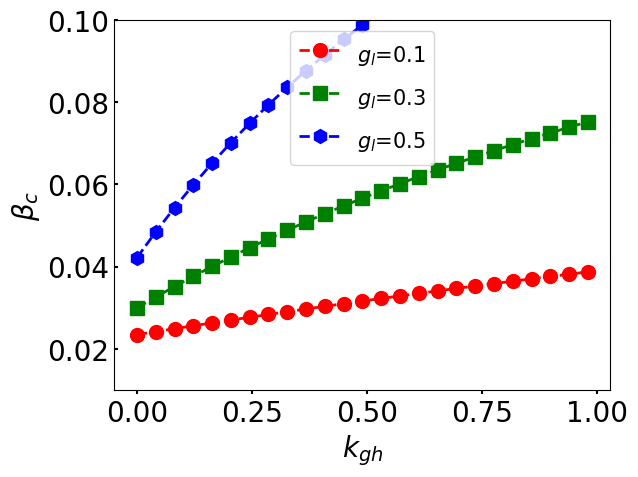

In [4]:
index_gl = [10,29,49]
fig, ax = plt.subplots()

ax.plot(kgh_values.cpu()[::2], gl_kgh_threshold[index_gl[0],:][::2], marker="o", linestyle="--", color="red",\
         linewidth=2, markersize=10, label = r'$g_l$'+f'={gl_values.cpu()[index_gl[0]]:.1f}')  # 绘制第一条折线
ax.plot(kgh_values.cpu()[::2], gl_kgh_threshold[index_gl[1],:][::2], marker="s", linestyle="--", color="green",\
         linewidth=2, markersize=10, label = r'$g_l$'+f'={gl_values.cpu()[index_gl[1]]:.1f}')  # 绘制第一条折线
ax.plot(kgh_values.cpu()[::2], gl_kgh_threshold[index_gl[2],:][::2], marker="h", linestyle="--", color="blue",\
         linewidth=2, markersize=10, label = r'$g_l$'+f'={gl_values.cpu()[index_gl[2]]:.1f}')  # 绘制第一条折线


# 设置坐标轴标签
ax.set_xlabel(r'$k_{gh}$', fontsize=20, color='black')
ax.set_ylabel(r'$\beta_c$', fontsize=20, color='black')
ax.tick_params(axis='x', labelsize=20, length=3, width=1.5, color='black', direction='out')
ax.tick_params(axis='y', labelsize=20, length=3, width=1.5, color='black', direction='in')
# ax.set_xlim(0.0, 0.2)
ax.set_ylim(0.01, 0.1)

# 显示图形
ax.legend(fontsize=15, handlelength=2, handleheight=2)
# plt.yscale('log')
# plt.xscale('log')
plt.show()

fig.savefig(f'../figs/Threshold/kgh_beta.svg', bbox_inches='tight')

In [5]:
para_len = 50
node_num =  epi_paras.shape[0]
soc_paras_gl_kgm_mmca = soc_paras.unsqueeze(0).repeat(para_len, 1)
epi_paras_gl_kgm_mmca = epi_paras.unsqueeze(0).repeat(para_len, 1, 1)

#  替换掉自己的参数
gl_values = torch.linspace(0, 0.5, 50).to(device)
kgm_values = torch.linspace(0, 1, para_len).to(device)

epi_paras_gl_kgm_mmca[...,3] = 0.05

soc_paras_gl_kgm_mmca[...,5] = kgm_values 

mmca_threshold = MMCA_threshold()
gl_kgm_threshold = torch.zeros(gl_values.shape[0],kgh_values.shape[0])

init_pA =  torch.rand(para_len, node_num).to(device)
max_iter = 1000
tol = 1e-16
process = 0
for i in range(gl_values.shape[0]):
    soc_paras_gl_kgm_mmca[...,2] = gl_values[i]
    p_A = mmca_threshold.iteration(max_iter, tol, init_pA, epi_paras_gl_kgm_mmca, soc_paras_gl_kgm_mmca,\
                                    I_edge_index)
    beta_mu_3 = mmca_threshold.degree_MCMC_threshold(p_A, epi_paras_gl_kgm_mmca, soc_paras_gl_kgm_mmca, P_matrix)
    gl_kgm_threshold[i,:] = beta_mu_3
    process += 1
    print(f'已经完成第 {process} 个数据！')


已经完成第 1 个数据！
已经完成第 2 个数据！
已经完成第 3 个数据！
已经完成第 4 个数据！
已经完成第 5 个数据！
已经完成第 6 个数据！
已经完成第 7 个数据！
已经完成第 8 个数据！
已经完成第 9 个数据！
已经完成第 10 个数据！
已经完成第 11 个数据！
已经完成第 12 个数据！
已经完成第 13 个数据！
已经完成第 14 个数据！
已经完成第 15 个数据！
已经完成第 16 个数据！
已经完成第 17 个数据！
已经完成第 18 个数据！
已经完成第 19 个数据！
已经完成第 20 个数据！
已经完成第 21 个数据！
已经完成第 22 个数据！
已经完成第 23 个数据！
已经完成第 24 个数据！
已经完成第 25 个数据！
已经完成第 26 个数据！
已经完成第 27 个数据！
已经完成第 28 个数据！
已经完成第 29 个数据！
已经完成第 30 个数据！
已经完成第 31 个数据！
已经完成第 32 个数据！
已经完成第 33 个数据！
已经完成第 34 个数据！
已经完成第 35 个数据！
已经完成第 36 个数据！
已经完成第 37 个数据！
已经完成第 38 个数据！
已经完成第 39 个数据！
已经完成第 40 个数据！
已经完成第 41 个数据！
已经完成第 42 个数据！
已经完成第 43 个数据！
已经完成第 44 个数据！
已经完成第 45 个数据！
已经完成第 46 个数据！
已经完成第 47 个数据！
已经完成第 48 个数据！
已经完成第 49 个数据！
已经完成第 50 个数据！


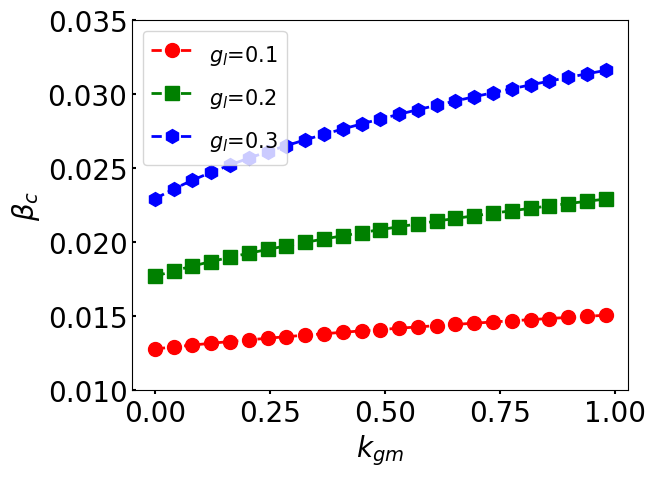

In [6]:
index_gl = [10,20,29]
fig, ax = plt.subplots()

ax.plot(kgm_values.cpu()[::2], gl_kgm_threshold[index_gl[0],:][::2], marker="o", linestyle="--", color="red",\
         linewidth=2, markersize=10, label = r'$g_l$'+f'={gl_values.cpu()[index_gl[0]]:.1f}')  # 绘制第一条折线
ax.plot(kgm_values.cpu()[::2], gl_kgm_threshold[index_gl[1],:][::2], marker="s", linestyle="--", color="green",\
         linewidth=2, markersize=10, label = r'$g_l$'+f'={gl_values.cpu()[index_gl[1]]:.1f}')  # 绘制第一条折线
ax.plot(kgm_values.cpu()[::2], gl_kgm_threshold[index_gl[2],:][::2], marker="h", linestyle="--", color="blue",\
         linewidth=2, markersize=10, label = r'$g_l$'+f'={gl_values.cpu()[index_gl[2]]:.1f}')  # 绘制第一条折线


# 设置坐标轴标签
ax.set_xlabel(r'$k_{gm}$', fontsize=20, color='black')
ax.set_ylabel(r'$\beta_c$', fontsize=20, color='black')
ax.tick_params(axis='x', labelsize=20, length=3, width=1.5, color='black', direction='out')
ax.tick_params(axis='y', labelsize=20, length=3, width=1.5, color='black', direction='in')
# ax.set_xlim(0.0, 0.2)
ax.set_ylim(0.01, 0.035)

# 显示图形
ax.legend(fontsize=15, handlelength=2, handleheight=2)
# plt.yscale('log')
# plt.xscale('log')
plt.show()
fig.savefig(f'../figs/Threshold/kgm_beta.svg', bbox_inches='tight')


In [7]:
para_len = 50
node_num =  epi_paras.shape[0]
soc_paras_gl_mmca = soc_paras.unsqueeze(0).repeat(para_len, 1)
epi_paras_gl_mmca = epi_paras.unsqueeze(0).repeat(para_len, 1, 1)

#  替换掉自己的参数
gl_values = 10 ** torch.linspace(-2, 0, para_len).to(device)

mmca_threshold = MMCA_threshold()
gl_threshold = torch.zeros(gl_values.shape[0],kgh_values.shape[0])

init_pA =  torch.rand(para_len, node_num).to(device)
max_iter = 1000
tol = 1e-16
process = 0

p_A = mmca_threshold.iteration(max_iter, tol, init_pA, epi_paras_gl_kgm_mmca, soc_paras_gl_kgm_mmca,\
                                    I_edge_index)
beta_gl_3 = mmca_threshold.degree_MCMC_threshold(p_A, epi_paras_gl_kgm_mmca, soc_paras_gl_kgm_mmca, P_matrix)


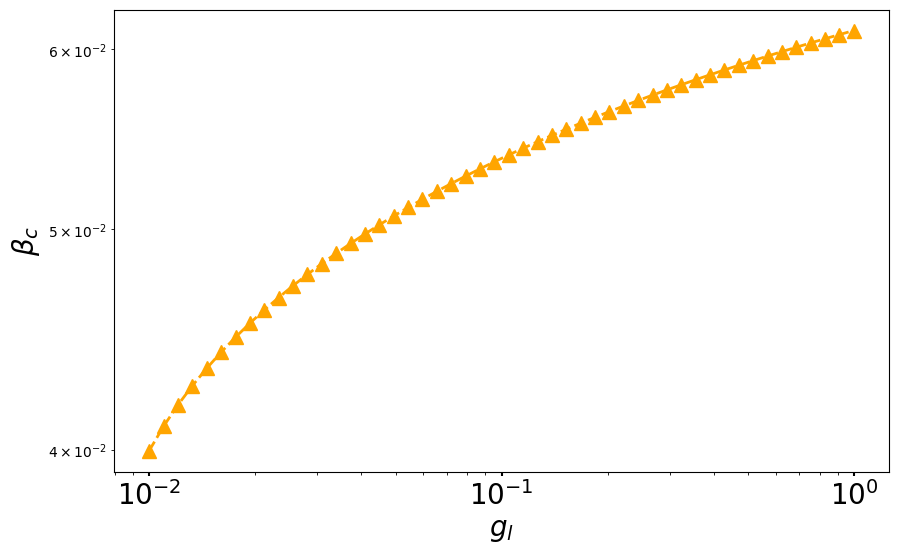

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(gl_values.cpu(), beta_gl_3, marker="^", linestyle="--", color="orange", linewidth=2, markersize=10)  # 绘制第一条折线


# 设置坐标轴标签
ax.set_xlabel(r'$g_l$', fontsize=20, color='black')
ax.set_ylabel(r'$\beta_c$', fontsize=20, color='black')
ax.tick_params(axis='x', labelsize=20, length=3, width=1.5, color='black', direction='out')
ax.tick_params(axis='y', labelsize=20, length=3, width=1.5, color='black', direction='in')
# ax.set_xlim(0.0, 0.5)
# ax.set_ylim(3*10**(-2), 6*10**(-1.0))

# 显示图形
# ax.legend(fontsize=15, handlelength=2, handleheight=2)
plt.yscale('log')
plt.xscale('log')
plt.show()

# plt.savefig(f'../figs/Num_verification/Threshold/mu_beta.svg', bbox_inches='tight')